dasn ce projet j'ai fait plusieurs étapes clés pour évaluer et améliorer la robustesse des modèles de machine learning face aux attaques adversariales que je les ai trouvé sur les slides  :

1. **Modélisation et Prédiction Initiales**
2. **Attaques Adversariales**
3. **Test du Modèle**
4. **Visualisation**
5. **Entraînement Adversarial**

j'ai travailler avec deux methode d'attack, le fgsm et le pgd sur les donnes FashionMnist

## FGSM


In [ ]:
!pip install torch


  Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl (906.4 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.7.1.2
    Uninstalling nvidia-cusolver-cu12-11.7.1.2:
      Successfully uninstalled nvidia-cusolver-cu12-11.7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.0+cu121 requires torch==2.5.0, but you have torch 2.5.1 which is incompatible.
to

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Configuration du dispositif
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:

# Définitions des transformations pour chaque dataset
transform_mnist_fashion = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform_cifar10_svhn_celeba = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [ ]:
# Chargement des datasets


In [ ]:
trainloader_fashion = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_mnist_fashion),
    batch_size=64, shuffle=True)
testloader_fashion = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_mnist_fashion),
    batch_size=64, shuffle=False)

In [ ]:


# Modèle simple de réseau de neurones
class SimpleCNN28(nn.Module):
    """Modèle pour les images de taille 28x28 (MNIST, FashionMNIST)"""
    def __init__(self, input_channels=1):
        super(SimpleCNN28, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialisation de la fonction de perte et de l'optimizer
criterion = nn.CrossEntropyLoss()

# Fonction d'attaque FGSM
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

# Fonction de test avec FGSM
def test_fgsm(model, testloader, epsilon):
    correct = 0
    adv_examples = []
    model.eval()

    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()

        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        correct += (final_pred == target).sum().item()

    final_acc = correct / float(len(testloader.dataset))
    print(f'Epsilon: {epsilon}\tTest Accuracy = {final_acc * 100:.2f}%')

# Entraînement et test pour chaque dataset
def train_and_evaluate(dataset_name, trainloader, testloader, model, epsilon=0.3):
    print(f"\nTraining and evaluating FGSM on {dataset_name} dataset")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraînement du modèle
    model.train()
    for epoch in range(3):  # Entraîner pour 3 époques pour cet exemple
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Test FGSM
    test_fgsm(model, testloader, epsilon)





In [ ]:
# Tester sur chaque dataset
model_fashion = SimpleCNN28(input_channels=1).to(device)
train_and_evaluate("FashionMNIST", trainloader_fashion, testloader_fashion, model=model_fashion, epsilon=0.3)



Training and evaluating FGSM on FashionMNIST dataset
Epsilon: 0.3	Test Accuracy = 643.39%


In [ ]:
import matplotlib.pyplot as plt

def visualize_attack(model, testloader, epsilon, input_channels=1, dataset_name="Dataset"):
    """
    Visualise l'effet de l'attaque FGSM sur un modèle en affichant des images originales et perturbées.

    Arguments :
    - model : Le modèle entraîné sur lequel effectuer l'attaque.
    - testloader : DataLoader contenant le jeu de test.
    - epsilon : Magnitude de la perturbation pour FGSM.
    - input_channels : Nombre de canaux d'entrée (1 pour les images en niveaux de gris, 3 pour les images en couleur).
    - dataset_name : Nom du dataset, utilisé pour distinguer les images dans les annotations.
    """

    # Extraire un batch de données
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Générer une attaque FGSM
    images.requires_grad = True
    output = model(images)
    loss = criterion(output, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    perturbed_data = fgsm_attack(images, epsilon, data_grad)

    # Créer la figure
    fig, axes = plt.subplots(2, 6, figsize=(12, 5))
    fig.suptitle(f"FGSM Attack Visualization on {dataset_name} (Epsilon: {epsilon})", fontsize=16)

    for i in range(6):
        # Image originale
        ax = axes[0, i]
        original_img = images[i].detach().cpu().numpy()
        if input_channels == 1:
            ax.imshow(original_img.squeeze(), cmap="gray")
        else:
            ax.imshow(original_img.transpose(1, 2, 0))
        ax.axis("off")
        ax.set_title("Original")

        # Image perturbée
        ax = axes[1, i]
        perturbed_img = perturbed_data[i].detach().cpu().numpy()
        if input_channels == 1:
            ax.imshow(perturbed_img.squeeze(), cmap="gray")
        else:
            ax.imshow(perturbed_img.transpose(1, 2, 0))
        ax.axis("off")
        ax.set_title("Perturbé")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuster l'espace pour le titre principal
    plt.show()


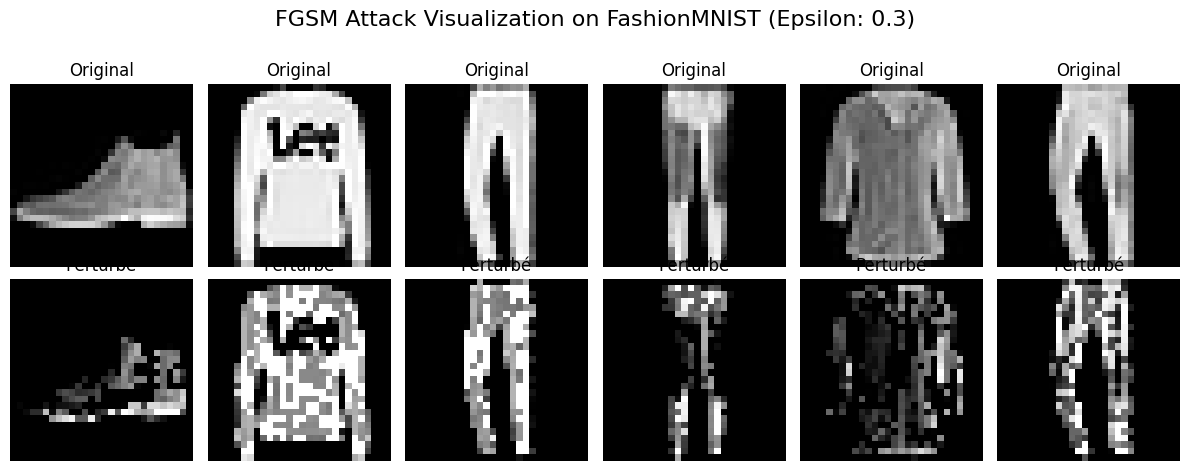

In [ ]:
# Visualiser l'attaque FGSM sur MNIST
visualize_attack(model_fashion, testloader_fashion, epsilon=0.3, input_channels=1, dataset_name="FashionMNIST")


In [ ]:
def certify_robustness(model, testloader, epsilon, input_channels=1):
    """
    Certifie que les prédictions du modèle sont robustes sous une perturbation FGSM de magnitude epsilon.

    Arguments :
    - model : Le modèle à tester.
    - testloader : Le DataLoader pour le jeu de test.
    - epsilon : La magnitude de la perturbation.
    - input_channels : Le nombre de canaux d'entrée (1 pour les images en niveaux de gris, 3 pour les images en couleur).
    """
    model.eval()
    correct_certified = 0
    total = 0

    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        total += target.size(0)

        # Prédiction initiale
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        # Bornes inférieure et supérieure pour les perturbations
        lower_bound = torch.clamp(data - epsilon, 0, 1)
        upper_bound = torch.clamp(data + epsilon, 0, 1)

        # Prédictions pour les bornes
        lower_output = model(lower_bound)
        upper_output = model(upper_bound)
        lower_pred = lower_output.max(1, keepdim=True)[1]
        upper_pred = upper_output.max(1, keepdim=True)[1]

        # Certifier si les prédictions restent stables
        is_certified = (lower_pred == init_pred).all(dim=1) & (upper_pred == init_pred).all(dim=1)
        correct_certified += is_certified.sum().item()

    # Calcul du taux de robustesse certifié
    final_certified_acc = correct_certified / total
    print(f'Certified robustness for epsilon {epsilon}: {final_certified_acc * 100:.2f}% over {total} samples.')


In [ ]:
# Exécuter la certification de robustesse pour FashionMNIST
certify_robustness(model_fashion, testloader_fashion, epsilon=0.3, input_channels=1)


Certified robustness for epsilon 0.3: 47.70% over 10000 samples.


In [ ]:
def adversarial_training(model, train_loader, epsilon, num_epochs=10):
    # Placer le modèle en mode entraînement
    model.train()

    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zéro gradients
            optimizer.zero_grad()

            # Calculer les perturbations adversariales sur les images d'entraînement
            images.requires_grad = True
            outputs = model(images)
            loss = criterion(outputs, labels)
            model.zero_grad()
            loss.backward()
            data_grad = images.grad.data

            # Créer des images adversariales en appliquant FGSM
            perturbed_images = fgsm_attack(images, epsilon, data_grad)

            # Ré-entraînement sur les images perturbées
            outputs_adv = model(perturbed_images)
            loss_adv = criterion(outputs_adv, labels)
            loss_adv.backward()
            optimizer.step()

        # Affichage de la perte moyenne après chaque époque
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


In [ ]:
def test_model(model, test_loader, epsilon):
    correct = 0
    total = 0
    adv_examples = []

    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True

        # Forward pass the data through the model
        outputs = model(images)
        _, init_pred = outputs.max(1)  # Get the index of the max log-probability

        # Loop over the batch
        for idx in range(images.size(0)):
            original_image = images[idx]
            init_prediction = init_pred[idx]
            label = labels[idx]

            if init_prediction == label:
                # Calculate loss only for correct predictions to generate adversarial examples
                loss = criterion(outputs[idx].unsqueeze(0), labels[idx].unsqueeze(0))
                model.zero_grad()
                loss.backward(retain_graph=True)
                data_grad = images.grad.data[idx]

                # Generate adversarial example
                perturbed_data = fgsm_attack(original_image.unsqueeze(0), epsilon, data_grad.unsqueeze(0))
                output = model(perturbed_data)
                final_pred = output.max(1)[1]

                if final_pred.item() == label.item():
                    correct += 1
                if len(adv_examples) < 5:  # Save some examples to visualize
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_prediction.item(), final_pred.item(), adv_ex))

        total += images.size(0)

    # Calculate final accuracy
    final_acc = correct / float(total)
    print(f'Epsilon: {epsilon}, Test Accuracy: {final_acc * 100:.2f}%')
    return adv_examples


In [ ]:
def visualize_results(adv_examples):
    plt.figure(figsize=(10, 5))
    for i, (init_pred, final_pred, ex) in enumerate(adv_examples):
        plt.subplot(1, len(adv_examples), i+1)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title(f"{init_pred} -> {final_pred}")
        plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()


Epsilon: 0.1, Test Accuracy: 35.59%


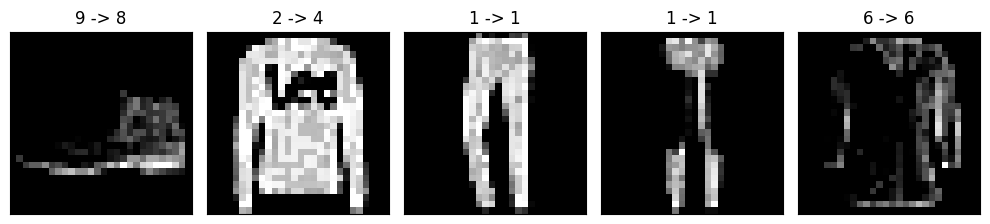

In [ ]:
# Assume epsilon = 0.1 has been set
adv_examples = test_model(model_fashion, testloader_fashion, epsilon=0.1)
visualize_results(adv_examples)


## PGD

In [ ]:
import torch

def pgd_attack(model, images, labels, epsilon, alpha, num_iter):
    """
    Effectue une attaque PGD sur les images.

    Arguments :
    - model : le modèle à attaquer.
    - images : les images d'entrée.
    - labels : les étiquettes correctes des images.
    - epsilon : le maximum de perturbation.
    - alpha : la taille de chaque étape.
    - num_iter : le nombre d'itérations de PGD.

    Retourne :
    - perturbed_images : les images perturbées.
    """
    perturbed_images = images.clone().detach().to(images.device)
    perturbed_images.requires_grad = True

    for i in range(num_iter):
        outputs = model(perturbed_images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()

        # Calculer la perturbation et mettre à jour les images
        grad = perturbed_images.grad.data
        perturbed_images = perturbed_images + alpha * grad.sign()

        # Projeter les images perturbées pour rester dans l'intervalle epsilon autour des images d'origine
        perturbed_images = torch.max(torch.min(perturbed_images, images + epsilon), images - epsilon)
        perturbed_images = torch.clamp(perturbed_images, 0, 1)
        perturbed_images = perturbed_images.detach()
        perturbed_images.requires_grad = True

    return perturbed_images


In [ ]:
def visualize_attack_pgd(model, testloader, epsilon, alpha, num_iter, input_channels=1, dataset_name="Dataset"):
    """
    Visualise l'effet de l'attaque PGD sur un modèle en affichant des images originales et perturbées.
    """
    # Extraire un batch de données
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Générer une attaque PGD
    perturbed_data = pgd_attack(model, images, labels, epsilon, alpha, num_iter)

    # Créer la figure
    fig, axes = plt.subplots(2, 6, figsize=(12, 5))
    fig.suptitle(f"PGD Attack Visualization on {dataset_name} (Epsilon: {epsilon}, Alpha: {alpha}, Iterations: {num_iter})", fontsize=16)

    for i in range(6):
        # Image originale
        ax = axes[0, i]
        original_img = images[i].detach().cpu().numpy()
        if input_channels == 1:
            ax.imshow(original_img.squeeze(), cmap="gray")
        else:
            ax.imshow(original_img.transpose(1, 2, 0))
        ax.axis("off")
        ax.set_title("Original")

        # Image perturbée
        ax = axes[1, i]
        perturbed_img = perturbed_data[i].detach().cpu().numpy()
        if input_channels == 1:
            ax.imshow(perturbed_img.squeeze(), cmap="gray")
        else:
            ax.imshow(perturbed_img.transpose(1, 2, 0))
        ax.axis("off")
        ax.set_title("Perturbé")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuster l'espace pour le titre principal
    plt.show()


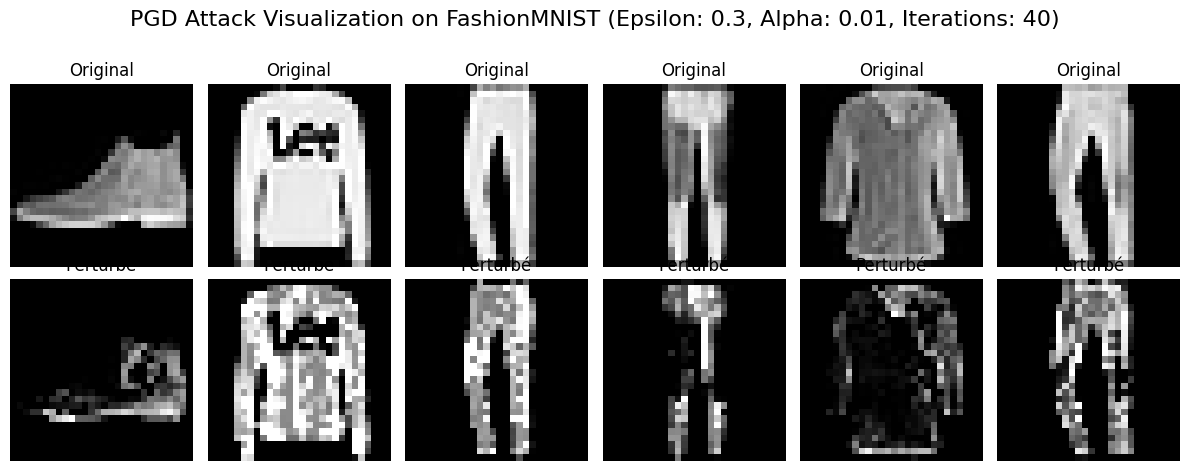

In [ ]:
# Visualiser l'attaque PGD sur FashionMNIST
visualize_attack_pgd(model_fashion, testloader_fashion, epsilon=0.3, alpha=0.01, num_iter=40, input_channels=1, dataset_name="FashionMNIST")


In [ ]:
def certify_robustness_pgd(model, testloader, epsilon, alpha, num_iter, input_channels=1):
    """
    Certifie que les prédictions du modèle sont robustes sous une perturbation PGD de magnitude epsilon.
    """
    model.eval()
    correct_certified = 0
    total = 0

    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        total += target.size(0)

        # Générer des images perturbées avec PGD
        perturbed_data = pgd_attack(model, data, target, epsilon, alpha, num_iter)

        # Prédiction pour les images perturbées
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        correct_certified += (final_pred == target.view_as(final_pred)).sum().item()

    # Calcul du taux de robustesse certifié
    final_certified_acc = correct_certified / total
    print(f'Certified robustness for PGD attack (epsilon={epsilon}, alpha={alpha}, iterations={num_iter}): {final_certified_acc * 100:.2f}%')


In [ ]:
certify_robustness_pgd(model_fashion, testloader_fashion, epsilon=0.3, alpha=0.01, num_iter=40, input_channels=1)


Certified robustness for PGD attack (epsilon=0.3, alpha=0.01, iterations=40): 2.68%


In [ ]:
def adversarial_training_pgd(model, train_loader, epsilon, alpha, num_iter, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            perturbed_images = pgd_attack(model, images, labels, epsilon, alpha, num_iter)
            outputs_adv = model(perturbed_images)
            loss_adv = criterion(outputs_adv, labels)
            loss_adv.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {loss_adv.item()}')


In [ ]:
def test_model_pgd(model, test_loader, epsilon, alpha, num_iter):
    correct = 0
    total = 0
    adv_examples = []

    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        perturbed_data = pgd_attack(model, images, labels, epsilon, alpha, num_iter)
        outputs = model(perturbed_data)
        _, final_pred = outputs.max(1)

        total += labels.size(0)
        correct += (final_pred == labels).sum().item()

        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append((final_pred.item(), labels.item(), adv_ex))

    final_acc = correct / float(total)
    print(f'Epsilon: {epsilon}, Alpha: {alpha}, Num Iter: {num_iter}, Test Accuracy: {final_acc * 100:.2f}%')
    return adv_examples


Epsilon: 0.1, Test Accuracy: 35.59%


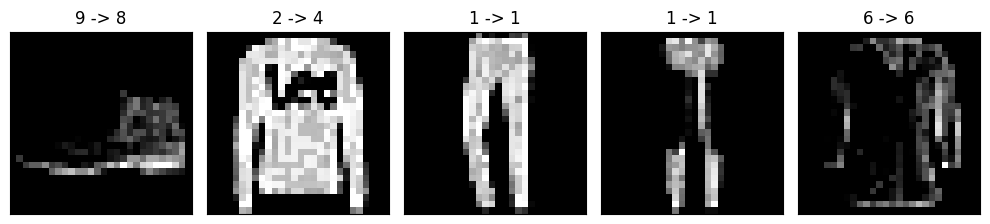

In [ ]:
adversarial_training = test_model(model_fashion, testloader_fashion, epsilon=0.1)
visualize_results(adversarial_training)